In [15]:
import argparse
import logging
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms

from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook

from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, roc_auc_score, auc

import utils
import models.net as net
import models.data_loader as data_loader

import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (30.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Configure Project

In [16]:
# Directory containing the .txt metadata about dataset
data_dir = 'data/4326'
layer_name = 'VIIRS_SNPP_CorrectedReflectance_TrueColor'
label_split = os.path.join(data_dir, layer_name + ".txt")

# Directory containing params.json
model_dir = 'experiments/pretrained_model'

# Name of the file in --model_dir containing weights to reload before training
restore_file = 'best' # 'best' or 'train' or None

### Training Function Definitions

In [17]:
def evaluate(model, loss_fn, dataloader, metrics, params):
    """Evaluate the model on `num_steps` batches.
    Args:
        model: (torch.nn.Module) the neural network
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches data
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
    """

    # set model to evaluation mode
    model.eval()

    # summary for current eval loop
    summ = []
    
    X = None
    outputs_prob = None
    outputs_pred = None
    labels = None

    # compute metrics over the dataset
    with tqdm_notebook(total=len(dataloader)) as t:
        for data_batch, labels_batch in dataloader:
            # move to GPU if available
            if params.cuda:
                data_batch, labels_batch = data_batch.cuda(async=True), labels_batch.cuda(async=True)
            # fetch the next evaluation batch
            data_batch, labels_batch = Variable(data_batch), Variable(labels_batch)

            # compute model output
            output_batch = model(data_batch)
            loss = loss_fn(output_batch, labels_batch)

            # extract data from torch Variable, move to cpu, convert to numpy arrays
            output_batch = output_batch.data.cpu().numpy()
            output_pred_batch = np.argmax(output_batch, axis=1)
            labels_batch = labels_batch.data.cpu().numpy()

            # save the outputs and labels
            if X is None:
                X = data_batch
                outputs_prob = output_batch
                outputs_pred = output_pred_batch
                labels = labels_batch
            else:
                X = np.append(X, data_batch, axis=0)
                outputs_prob = np.append(outputs_prob, output_batch, axis=0)
                outputs_pred = np.append(outputs_pred, output_pred_batch, axis=0)
                labels = np.append(labels, labels_batch, axis=0)

            # compute all metrics on this batch
            summary_batch = {metric: metrics[metric](output_batch, labels_batch)
                             for metric in metrics}
            summary_batch['loss'] = loss.data[0]
            summ.append(summary_batch)

    # compute mean of all metrics in summary
    metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]} 
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
    logging.info("- Eval metrics : " + metrics_string)
    
    return X, outputs_prob, outputs_pred, labels, metrics_mean

def train(model, optimizer, loss_fn, dataloader, metrics, params):
    """Train the model on `num_steps` batches
    Args:
        model: (torch.nn.Module) the neural network
        optimizer: (torch.optim) optimizer for parameters of model
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches training data
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
    """

    # set model to training mode
    model.train()

    # summary for current training loop and a running average object for loss
    summ = []
    loss_avg = utils.RunningAverage()

    # Use tqdm for progress bar
    with tqdm_notebook(total=len(dataloader)) as t:
        for i, (train_batch, labels_batch) in enumerate(dataloader):
            # move to GPU if available
            if params.cuda:
                train_batch, labels_batch = train_batch.cuda(async=True), labels_batch.cuda(async=True)
            # convert to torch Variables
            train_batch, labels_batch = Variable(train_batch), Variable(labels_batch)

            # compute model output and loss
            output_batch = model(train_batch)
            loss = loss_fn(output_batch, labels_batch)

            # clear previous gradients, compute gradients of all variables wrt loss
            optimizer.zero_grad()
            loss.backward()

            # performs updates using calculated gradients
            optimizer.step()

            # Evaluate summaries only once in a while
            if i % params.save_summary_steps == 0:
                # extract data from torch Variable, move to cpu, convert to numpy arrays
                output_batch = output_batch.data.cpu().numpy()
                labels_batch = labels_batch.data.cpu().numpy()

                # compute all metrics on this batch
                summary_batch = {metric:metrics[metric](output_batch, labels_batch)
                                 for metric in metrics}
                summary_batch['loss'] = loss.data[0]
                summ.append(summary_batch)

            # update the average loss
            loss_avg.update(loss.data[0])

            t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
            t.update()

    # compute mean of all metrics in summary
    metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]}
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
    logging.info("- Train metrics: " + metrics_string)


def train_and_evaluate(model, train_dataloader, val_dataloader, optimizer, loss_fn, metrics, params, model_dir,
                       restore_file=None):
    """Train the model and evaluate every epoch.
    Args:
        model: (torch.nn.Module) the neural network
        train_dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches training data
        val_dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches validation data
        optimizer: (torch.optim) optimizer for parameters of model
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
        model_dir: (string) directory containing config, weights and log
        restore_file: (string) optional- name of file to restore from (without its extension .pth.tar)
    """
    # reload weights from restore_file if specified
    if restore_file is not None:
        restore_path = os.path.join(model_dir, restore_file + '.pth.tar')
        logging.info("Restoring parameters from {}".format(restore_path))
        utils.load_checkpoint(restore_path, model, optimizer)

    best_val_score = 0.0

    for epoch in range(params.num_epochs):
        # Run one epoch
        logging.info("Epoch {}/{}".format(epoch + 1, params.num_epochs))

        # compute number of batches in one epoch (one full pass over the training set)
        train(model, optimizer, loss_fn, train_dataloader, metrics, params)

        # Evaluate for one epoch on validation set
        _, _, _, _, val_metrics = evaluate(model, loss_fn, val_dataloader, metrics, params)

        val_score = val_metrics['AUC']
        is_best = val_score>best_val_score

        # Save weights
        utils.save_checkpoint({'epoch': epoch + 1,
                               'state_dict': model.state_dict(),
                               'optim_dict' : optimizer.state_dict()},
                               is_best=is_best,
                               checkpoint=model_dir)

        # If best_eval, best_save_path
        if is_best:
            logging.info("- Found new best accuracy")
            print("best_val_score {:05.3f}".format(best_val_score))
            print("val_score {:05.3f}".format(val_score))
            best_val_score = val_score

            # Save best val metrics in a json file in the model directory
            best_json_path = os.path.join(model_dir, "metrics_val_best_weights.json")
            utils.save_dict_to_json(val_metrics, best_json_path)

        # Save latest val metrics in a json file in the model directory
        last_json_path = os.path.join(model_dir, "metrics_val_last_weights.json")
        utils.save_dict_to_json(val_metrics, last_json_path)

### Load Hyperparameters from File

In [18]:
json_path = os.path.join(model_dir, 'params.json')
assert os.path.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = utils.Params(json_path)

# use GPU if available
params.cuda = torch.cuda.is_available()
print("GPU available: {}".format(params.cuda))

# Set the random seed for reproducible experiments
torch.manual_seed(230)
if params.cuda: torch.cuda.manual_seed(230)

GPU available: False


### Define the Model, Loss, and Optimizer

In [ ]:
# Define the model and optimizer
model = models.densenet121(pretrained='imagenet').cuda() if params.cuda else models.densenet121(pretrained='imagenet')

# Freeze all the layers!
for param in model.parameters():
    param.requires_grad = False

# Change the last layer to our number of classes
# Parameters of newly constructed modules have requires_grad=True by default
n_features = model.classifier.in_features
n_class = 2
model.classifier = nn.Linear(n_features, n_class).cuda() if params.cuda else nn.Linear(n_features, n_class)

# Unfreeze the last layer
for param in model.classifier.parameters():
    param.requires_grad = True

# Define the loss
loss_fn = nn.CrossEntropyLoss()

# Optimize only the classifier
optimizer = optim.Adam(model.classifier.parameters(), lr=params.learning_rate)

### Define Metrics

In [6]:
# Fetch metrics
def accuracy(outputs, labels):
    """
    Compute the accuracy, given the outputs and labels for all images.

    Args:
        outputs: (np.ndarray) dimension batch_size x 2 - log softmax output of the model
        labels: (np.ndarray) dimension batch_size, where each element is a value in [0, 1]

    Returns: (float) accuracy in [0,1]
    """
    outputs = np.argmax(outputs, axis=1)
    return np.sum(outputs==labels)/float(labels.size)

def recall(outputs, labels):
    """
    Compute the recall, given the outputs and labels for all images.

    Args:
        outputs: (np.ndarray) dimension batch_size x 2 - log softmax output of the model
        labels: (np.ndarray) dimension batch_size, where each element is a value in [0, 1]

    Returns: (float) recall in [0,1]
    """
    outputs = np.argmax(outputs, axis=1)
    return recall_score(labels, outputs)

def precision(outputs, labels):
    """
    Compute the precision, given the outputs and labels for all images. 
    
    The precision is the ratio tp / (tp + fp) where tp is the number 
    of true positives and fp the number of false positives. 
    
    The precision is intuitively the ability of the classifier not to 
    label as positive a sample that is negative.
    
    The best value is 1 and the worst value is 0.
    
    Args:
        outputs: (np.ndarray) dimension batch_size x 2 - log softmax output of the model
        labels: (np.ndarray) dimension batch_size, where each element is a value in [0, 1]

    Returns: (float) precision in [0,1]
    """
    outputs = np.argmax(outputs, axis=1)
    return precision_score(labels, outputs)

def f1_metric(outputs, labels):
    """
    Compute the F1 score, given the outputs and labels for all images.

    Args:
        outputs: (np.ndarray) dimension batch_size x 2 - log softmax output of the model
        labels: (np.ndarray) dimension batch_size, where each element is a value in [0, 1]

    Returns: (float) F1 score in [0,1]
    """
    outputs = np.argmax(outputs, axis=1)
    return f1_score(labels, outputs)

def roc_graph(outputs, labels):
    """
    Compute Receiver operating characteristic (ROC).
    
    Args:
        outputs: (np.ndarray) dimension batch_size x 2 - log softmax output of the model
        labels: (np.ndarray) dimension batch_size, where each element is a value in [0, 1]
        
    Returns: fpr, tpr, thresholds
    """
    outputs = np.argmax(outputs, axis=1)
    return roc_curve(labels, outputs)

def roc_auc_metric(outputs, labels):
    """
    Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    """
    outputs = np.argmax(outputs, axis=1)
    return roc_auc_score(labels, outputs)

# maintain all metrics required in this dictionary- these are used in the training and evaluation loops
metrics = {
    'AUC': roc_auc_metric, # area under receiver operator characteristic curve
    'F1': f1_metric, # weighted average of precision and recall
    'recall': recall, 
    'precision': precision,
    'accuracy': accuracy,
    # could add more metrics such as accuracy for each token type
}

/Users/xue/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


### Train the Model

In [ ]:
# Set the logger
utils.set_logger(os.path.join(model_dir, 'train.log'))

# Create the input data pipeline
logging.info("Loading the datasets...")

# Set the model input size
IMG_DIM = (112, 224)
IMG_PADDING = (0, 56, 0, 56) # left, top, right, bottom borders
IMG_BINARIZE = False

# Apply normalization for Densenet pretrained model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

# borrowed from http://pytorch.org/tutorials/advanced/neural_style_tutorial.html
# and http://pytorch.org/tutorials/beginner/data_loading_tutorial.html
# define a training image loader that specifies transforms on images. See documentation for more details.
train_transformer = transforms.Compose([
    transforms.Resize(IMG_DIM),  # resize the image 
    transforms.Pad(padding=IMG_PADDING, fill=0), # pad to be square!
    transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
    transforms.RandomVerticalFlip(), # randomly flip image vertically
    transforms.ToTensor(), # transform it into a torch tensor
    # normalize,
    ])  

# loader for evaluation, no data augmentation (e.g. horizontal flip)
eval_transformer = transforms.Compose([
    transforms.Resize(IMG_DIM),  # resize the image
    transforms.Pad(padding=IMG_PADDING, fill=0), # pad to be square!
    transforms.ToTensor(), # transform it into a torch tensor
    # normalize,
    ])  

# fetch dataloaders
train_dl = data_loader.fetch_dataloader('train', train_transformer, data_dir, layer_name, label_split, params, IMG_BINARIZE)
val_dl = data_loader.fetch_dataloader('val', eval_transformer, data_dir, layer_name, label_split, params, IMG_BINARIZE)

logging.info("- done.")

In [51]:
# Train the model
logging.info("Starting training for {} epoch(s)".format(params.num_epochs))
train_and_evaluate(model, train_dl, val_dl, optimizer, loss_fn, metrics, params, model_dir, restore_file)

Starting training for 100 epoch(s)
Restoring parameters from experiments/pretrained_model/best.pth.tar
Epoch 1/100


/Users/xue/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/xue/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
- Train metrics: AUC: 0.516 ; F1: 0.246 ; recall: 0.778 ; precision: 0.146 ; accuracy: 0.328 ; loss: 0.801


/Users/xue/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
- Eval metrics : AUC: 0.399 ; F1: 0.142 ; recall: 0.689 ; precision: 0.081 ; accuracy: 0.175 ; loss: 0.876


- Found new best accuracy
Epoch 2/100


best_val_score 0.000
val_score 0.399


Process Process-173:
Process Process-174:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/xue/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/xue/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/xue/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/xue/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/Users/xue/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/Users/xue/Documents/gibs_ml/models/data_loader.py", line 87, in __getitem__
    image = Image.open(self.filenames[idx])  # PIL image
  File "/Users/xue/anaconda3/lib/pytho

  File "/Users/xue/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/xue/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/Users/xue/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/Users/xue/Documents/gibs_ml/models/data_loader.py", line 96, in __getitem__
    image = self.transform(image)
  File "/Users/xue/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py", line 49, in __call__
    img = t(img)
  File "/Users/xue/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py", line 175, in __call__
    return F.resize(img, self.size, self.interpolation)
  File "/Users/xue/anaconda3/li

RuntimeError: DataLoader worker (pid 52542) exited unexpectedly with exit code 1.

Process Process-176:
Traceback (most recent call last):
  File "/Users/xue/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/xue/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/xue/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/Users/xue/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/Users/xue/Documents/gibs_ml/models/data_loader.py", line 96, in __getitem__
    image = self.transform(image)
  File "/Users/xue/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py", line 49, in __call__
    img = t(img)
  File "/Users/xue/anaconda3/lib/python3.6/site-packages/torchvisi

### Evaluate Model on Test

In [73]:
# Get the logger
utils.set_logger(os.path.join(model_dir, 'evaluate.log'))

# Create the input data pipeline
logging.info("Creating the dataset...")

# fetch dataloaders
test_dl = data_loader.fetch_dataloader('test', eval_transformer, data_dir, layer_name, label_split, params, IMG_BINARIZE)

logging.info("- done.")

Creating the dataset...
- done.


In [74]:
for i, (data_batch, labels_batch) in enumerate(test_dl):
    if i == 20:
        print(data_batch.shape)
        img_batch = data_batch.numpy()
        img = np.transpose(img_batch[0], (1, 2, 0))
        plt.imshow(img.astype('uint8'))

In [54]:
logging.info("Starting evaluation")

# Reload weights from the saved file
utils.load_checkpoint(os.path.join(model_dir, restore_file + '.pth.tar'), model)

# Evaluate
X_test, y_test_prob, y_test_pred, y_test, test_metrics = evaluate(model, loss_fn, test_dl, metrics, params)
save_path = os.path.join(model_dir, "metrics_test_{}.json".format(restore_file))
utils.save_dict_to_json(test_metrics, save_path)

Starting evaluation


/Users/xue/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
- Eval metrics : AUC: 0.476 ; F1: 0.180 ; recall: 0.952 ; precision: 0.100 ; accuracy: 0.100 ; loss: 0.930


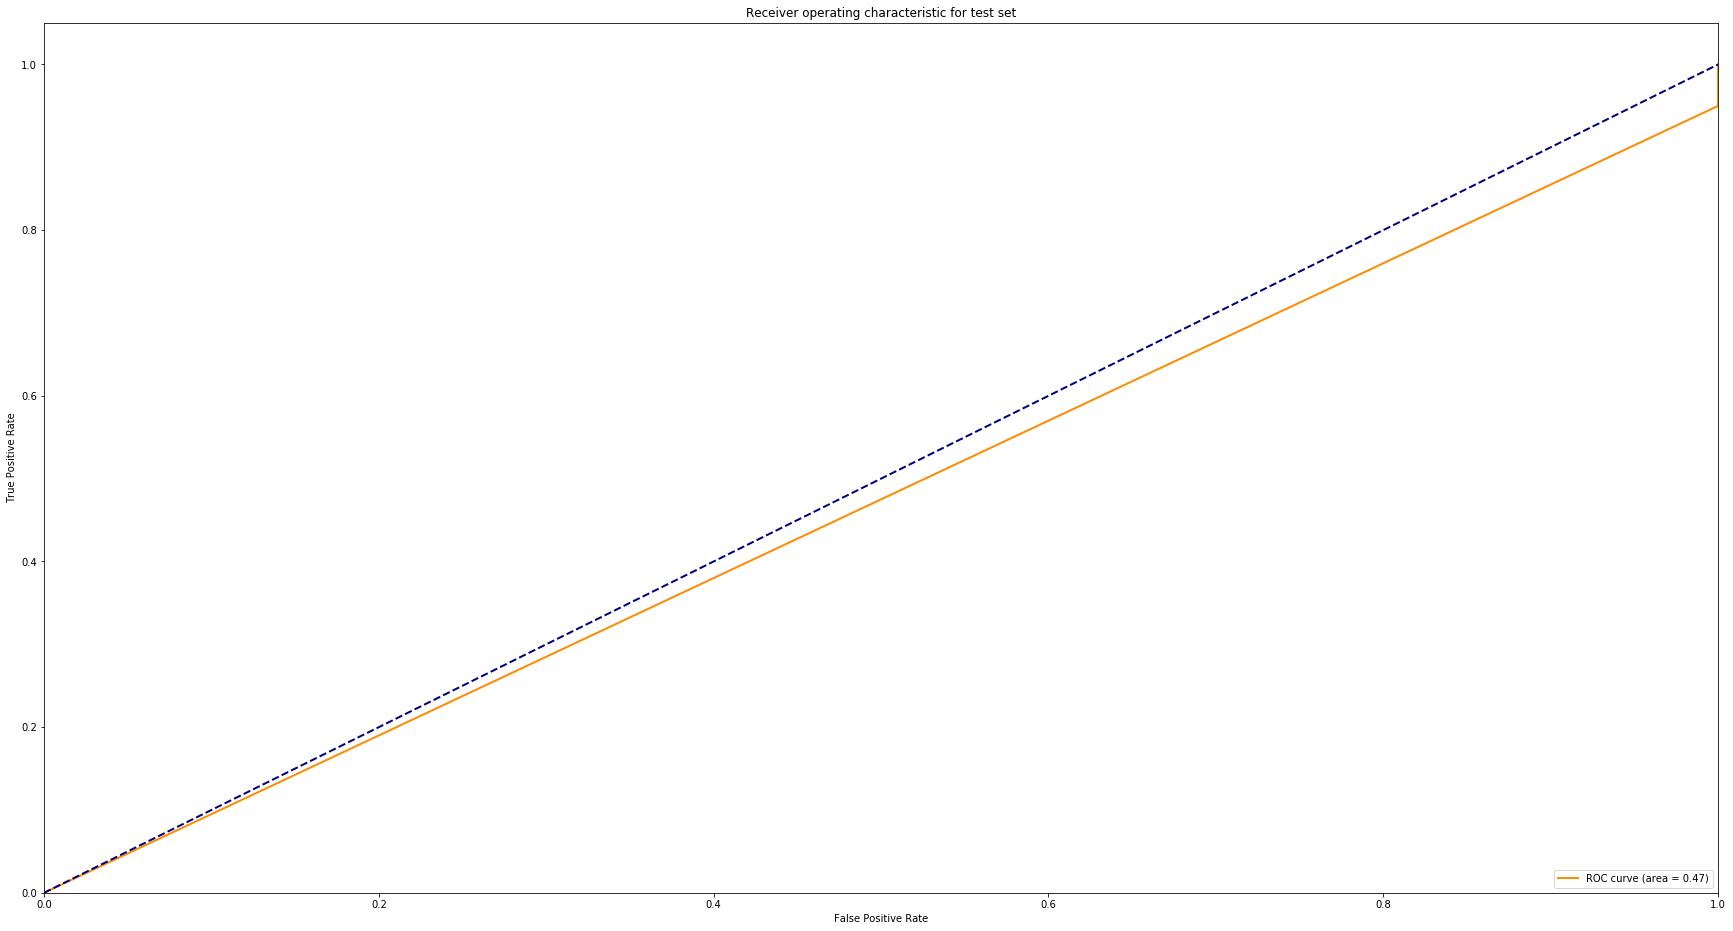

In [55]:
test_fpr, test_tpr, test_thresholds = roc_graph(y_test_prob, y_test)
test_roc_auc = auc(test_fpr, test_tpr)

plt.figure()
lw = 2
plt.plot(test_fpr, test_tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for test set')
plt.legend(loc="lower right")
plt.show()

Accuracy: 10.0%
Non-normalized conf_matrix:
[[  0.   1.]
 [170.  19.]]


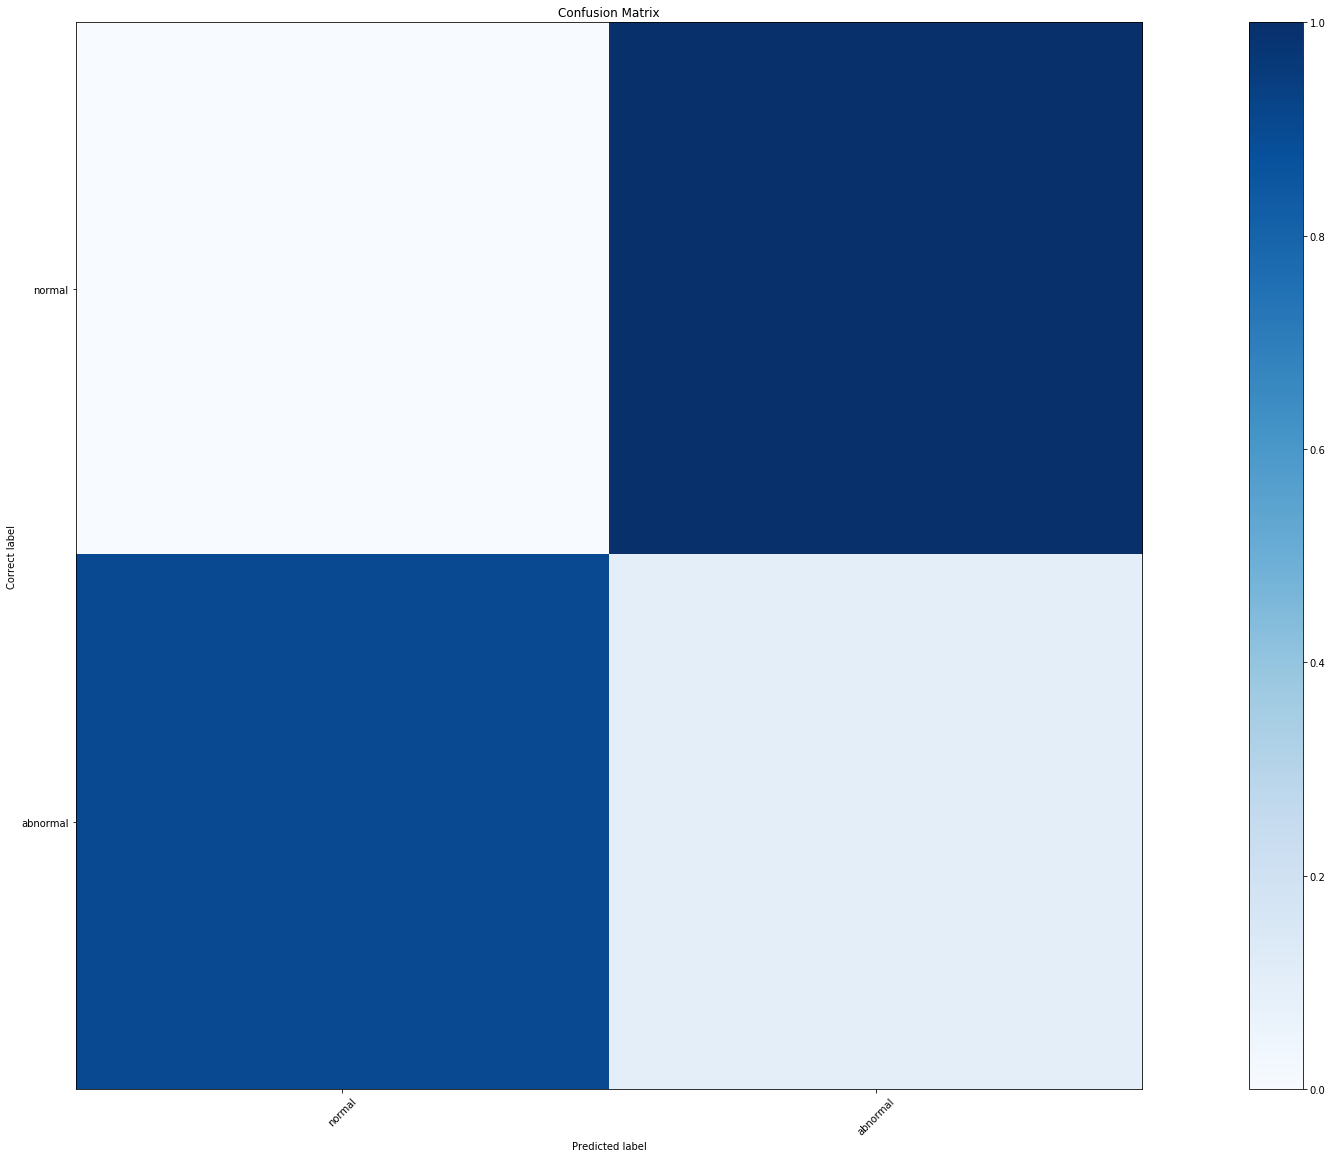

In [56]:
def confusion_matrix(results, categories, normalizeMatrix = True, plotConfusion=False):
    """ Generate confusion matrix
    - results = list of tuples of (correct label, predicted label)
    - categories = list of category names
    Returns confusion matrix; rows are correct labels and columns are predictions
    """
    # Empty confusion matrix
    matrix = np.zeros((len(categories),len(categories)))

    # Iterate over all labels and populate matrix
    for label, pred in results:
        matrix[label, pred] += 1

    # Print matrix and percent accuracy
    accuracy = float(np.trace(matrix)) * 100.0 / len(results)
    print('Accuracy: ' +  str(accuracy) + '%')

    # Normalize confusion matrix
    if normalizeMatrix:
      print("Non-normalized conf_matrix:")
      print(matrix)
      s = np.sum(matrix,1) # Sum each row
      for i in range(matrix.shape[0]):
        # Normalization handles class imbalance in training set
        matrix[i,:] /= s[i]

    # Save matrix to file:
    # np.save("confusion_matrix.npy",matrix)

    # Plot the confusion matrix
    if plotConfusion:
        plot_confusion_matrix(matrix, categories)

def plot_confusion_matrix(cm, names=None, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(4)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Add labels to confusion matrix:
    if names is None:
        names = range(cm.shape[0])

    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)

    plt.tight_layout()
    plt.ylabel('Correct label')
    plt.xlabel('Predicted label')
    plt.show()

classes = ['normal', 'abnormal']
confusion_matrix(list(zip(y_test_pred, y_test)), classes, plotConfusion=True)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


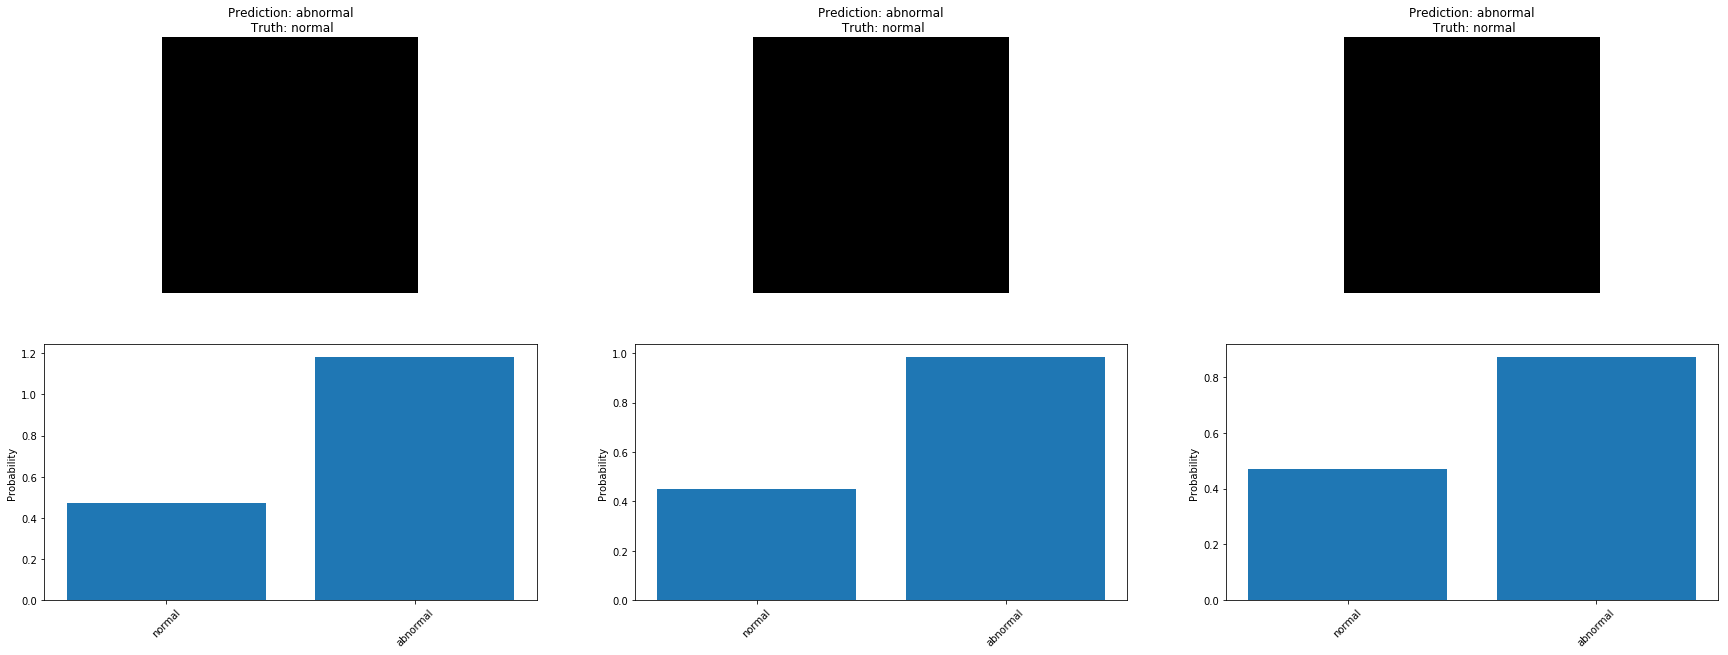

In [59]:
# Visualize misclassified examples from the validation dataset.
num_classes = len(classes)
max_examples = 3

incorrect_idx = [idx for idx, incorrect in enumerate(np.array(y_test) != np.array(y_test_pred)) if incorrect]
if len(incorrect_idx) > max_examples:
    incorrect_idx = incorrect_idx[:max_examples]
num_incorrect = len(incorrect_idx)

for y, idx in enumerate(incorrect_idx):
    for i in range(3):
        plt_idx = i * num_incorrect + y + 1
        if i == 0:
            plt.subplot(3, num_incorrect, plt_idx)
            #X_example = X_test[idx] * np.reshape(np.array([0.229, 0.224, 0.225]), (3, 1, 1))
            #X_example = X_example + np.reshape(np.array([0.485, 0.456, 0.406]), (3, 1, 1))
            #print(X_test[idx].shape)
            #print(X_test[idx].shape)            
            
            plt.imshow(np.transpose(X_test[idx], (1, 2, 0)).astype('uint8'))
            plt.axis('off')
            plt.title("Prediction: %s\n Truth: %s" % (classes[y_test_pred[idx]], classes[y_test[idx]]))
        elif i == 1:
            plt.subplot(3, num_incorrect, plt_idx)
            log_probabilities = y_test_prob[idx]
            probabilities = np.exp(log_probabilities)
            y_pos = np.arange(len(classes))
            plt.bar(y_pos, probabilities)
            plt.xticks(y_pos, classes, rotation=45)
            plt.ylabel("Probability")
plt.show()

In [ ]:
num_classes = len(classes)
# img_size = (16, 8)
# num_channels = 1

# Visualize the learned weights for each class.
finalconv_name = 'features'

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

model._modules.get(finalconv_name).register_forward_hook(hook_feature)


# w = model.fc2.weight.data.numpy() # convert to numpy arrays
# print(w.shape)
# w = w.reshape(num_classes, img_size[1], img_size[0], num_channels)
# w_min, w_max = np.min(w), np.max(w)
# for i in range(num_classes):
#     plt.subplot(2, 5, i + 1)
      
#     # Rescale the weights to be between 0 and 255
#     wimg = 255.0 * (w[i, :, :, :].squeeze() - w_min) / (w_max - w_min)
#     plt.imshow(wimg.astype('uint8'))
#     plt.axis('off')
#     plt.title(classes[i])